In [1]:
# ライブラリのインポート
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim

import argparse

# データの読み込みと前処理

In [2]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=500)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--patience', type=int, default=20) # earlystoppingの監視対象回数
parser.add_argument('--lr', type=int, default=0.001)
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, epochs=500, lr=0.001, patience=20)


In [3]:
# ダウンロード先のディレクトリ
root = './data'

# Transformオブジェクトを生成
transform = transforms.Compose(
    [transforms.ToTensor(), # Tensorオブジェクトに変換
     transforms.Normalize((0.5), (0.5)), # 平均0.5、標準偏差0.5で正規化
     lambda x: x.view(-1),   # データの形状を(28,28)から(784,)に変換
     ])

# 訓練用データの読み込み(60000セット)
f_mnist_train = datasets.FashionMNIST(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=True,    # 訓練データを指定
    transform=transform) # トランスフォーマーオブジェクトを指定

# テスト用データの読み込み(10000セット)
f_mnist_test = datasets.FashionMNIST(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=False,   # テストデータを指定
    transform=transform) # トランスフォーマーオブジェクトを指定

# 訓練用のデータローダー
train_dataloader = DataLoader(f_mnist_train, # 訓練データ
                              batch_size=opt.batch_size, # ミニバッチのサイズ
                              shuffle=True) # シャッフルして抽出

# テスト用のデータローダー
test_dataloader = DataLoader(f_mnist_test, # テストデータ
                             batch_size=opt.batch_size, # ミニバッチのサイズ
                             shuffle=False) # シャッフルして抽出

# データローダーが返すミニバッチの先頭データの形状を出力
for (x, t) in train_dataloader: # 訓練データ
    print(x.shape)
    print(t.shape)
    break

for (x, t) in test_dataloader: # テストデータ
    print(x.shape)
    print(t.shape)
    break

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

torch.Size([64, 784])
torch.Size([64])
torch.Size([64, 784])
torch.Size([64])


# モデルの定義

In [4]:
class MLP(nn.Module):
    '''多層パーセプトロン
    
    Attributes:
      l1(Linear) : 隠れ層
      l2(Linear) : 出力層
      d1(Dropout): ドロップアウト
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        '''モデルの初期化を行う
        
        Parameters:
          input_dim(int) : 入力する1データあたりの値の形状
          hidden_dim(int): 隠れ層のユニット数
          output_dim(int): 出力層のユニット数
          
        '''
        # スーパークラスの__init__()を実行
        super().__init__()
        # 隠れ層
        self.fc1 = nn.Linear(input_dim,  # 入力するデータのサイズ
                            hidden_dim)  # 隠れ層のニューロン数
        # ドロップアウト
        self.d1 = nn.Dropout(0.5)
        # 出力層
        self.fc2 = nn.Linear(hidden_dim, # 入力するデータのサイズ
                                         # (＝前層のニューロン数)
                            output_dim)  # 出力層のニューロン数
        
    def forward(self, x):
        '''MLPの順伝播処理を行う
        
        Parameters:
          x(ndarray(float32)):訓練データ、または検証データ
          
        Returns(float32):
          出力層からの出力値    
        '''
        # レイヤー、活性化関数に前ユニットからの出力を入力する
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.d1(x)
        x = self.fc2(x) # 最終出力は活性化関数を適用しない
        return x

# モデルの生成

In [5]:
# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルオブジェクトを生成し、使用可能なデバイスを設定する
model = MLP(784, 256, 10).to(device)

model # モデルの構造を出力

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (d1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# 損失関数とオプティマイザーの生成

In [6]:
# クロスエントロピー誤差のオブジェクトを生成
criterion = nn.CrossEntropyLoss()

# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = torch.optim.SGD(model.parameters(), lr=opt.lr)

# train_step()関数の定義

In [7]:
def train_step(x, t):
    '''バックプロパゲーションによるパラメーター更新を行う
    
    Parameters: x: 訓練データ
                t: 正解ラベル
                
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.train()    # モデルを訓練(学習)モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得
    optimizer.zero_grad() # 勾配を0で初期化（累積してしまうため）
    loss.backward()  # 逆伝播の処理(自動微分による勾配計算)
    optimizer.step() # 勾配降下法の更新式を適用してバイアス、重みを更新

    return loss, preds 

# test_step()関数の定義

In [8]:
def test_step(x, t):
    '''テストデータを入力して損失と予測値を返す
    
    Parameters: x: テストデータ
                t: 正解ラベル
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.eval()    # モデルを評価モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得

    return loss, preds 

# 学習の進捗を監視し早期終了判定を行うクラス

In [9]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# モデルを使用して学習する

In [10]:
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'loss':[],'accuracy':[], 'test_loss':[], 'test_accuracy':[]}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力
# 学習を行う
for epoch in range(opt.epochs):
    train_loss = 0. # 訓練1エポックあたりの損失を保持する変数
    train_acc = 0.  # 訓練1エポックごとの精度を保持する変数
    test_loss = 0. # 評価1エポックごとの損失を保持する変数
    test_acc = 0.  # 評価1エポックごとの精度を保持する変数

    # 1ステップにおける訓練用ミニバッチを使用した学習
    for (x, t) in train_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t) # 損失と予測値を取得
        train_loss += loss.item()      # ステップごとの損失を加算
        train_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 1ステップにおけるテストデータのミニバッチを使用した評価
    for (x, t) in test_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = test_step(x, t) # 損失と予測値を取得
        test_loss += loss.item()       # ステップごとの損失を加算
        test_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 訓練時の損失の平均値を取得
    avg_train_loss = train_loss / len(train_dataloader)
    # 訓練時の精度の平均値を取得
    avg_train_acc = train_acc / len(train_dataloader)
    # 検証時の損失の平均値を取得
    avg_test_loss = test_loss / len(test_dataloader)
    # 検証時の精度の平均値を取得
    avg_test_acc = test_acc / len(test_dataloader)

    # 訓練データの履歴を保存する
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)
    # テストデータの履歴を保存する
    history['test_loss'].append(avg_test_loss)
    history['test_accuracy'].append(avg_test_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc: {:.4} val_loss: {:.4} val_acc: {:.4}'.format(
                epoch+1,
                avg_train_loss, # 訓練データの損失を出力
                avg_train_acc,  # 訓練データの精度を出力
                avg_test_loss,  # テストデータの損失を出力
                avg_test_acc    # テストデータの精度を出力
    ))
    
    # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
    if ers(avg_test_loss):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break

epoch(1) train_loss: 2.222 train_acc: 0.1892 val_loss: 2.065 val_acc: 0.5253
epoch(2) train_loss: 1.991 train_acc: 0.353 val_loss: 1.839 val_acc: 0.5846
epoch(3) train_loss: 1.78 train_acc: 0.4468 val_loss: 1.638 val_acc: 0.632
epoch(4) train_loss: 1.604 train_acc: 0.5049 val_loss: 1.477 val_acc: 0.6414
epoch(5) train_loss: 1.466 train_acc: 0.5408 val_loss: 1.355 val_acc: 0.6636
epoch(6) train_loss: 1.361 train_acc: 0.5723 val_loss: 1.26 val_acc: 0.6766
epoch(7) train_loss: 1.278 train_acc: 0.5924 val_loss: 1.184 val_acc: 0.6855
epoch(8) train_loss: 1.209 train_acc: 0.6116 val_loss: 1.122 val_acc: 0.6969
epoch(9) train_loss: 1.154 train_acc: 0.6275 val_loss: 1.069 val_acc: 0.7008
epoch(10) train_loss: 1.107 train_acc: 0.6396 val_loss: 1.025 val_acc: 0.7073
epoch(11) train_loss: 1.067 train_acc: 0.6484 val_loss: 0.9863 val_acc: 0.7122
epoch(12) train_loss: 1.03 train_acc: 0.6585 val_loss: 0.9527 val_acc: 0.7138
epoch(13) train_loss: 0.9986 train_acc: 0.6667 val_loss: 0.9233 val_acc: 0.7

# 損失と精度の推移をグラフにする

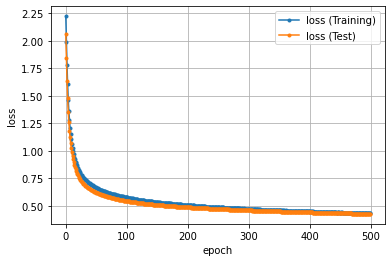

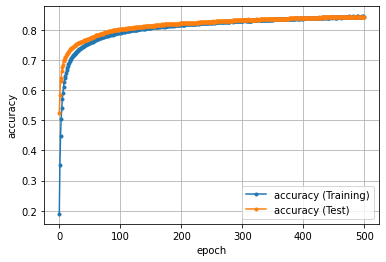

In [11]:
# 損失
plt.plot(history['loss'], marker='.', label='loss (Training)')
plt.plot(history['test_loss'], marker='.', label='loss (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 精度
plt.plot(history['accuracy'], marker='.', label='accuracy (Training)')
plt.plot(history['test_accuracy'], marker='.', label='accuracy (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()